In [8]:
import torch
import torchvision
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [9]:
dataset = MNIST(root='data/',download = True ,transform = transforms.ToTensor())

In [10]:
len(dataset)

60000

In [11]:
test_dataset = MNIST(root='data/' , train=False , transform = transforms.ToTensor())
len(test_dataset)

10000

In [13]:
img_tensor,label = dataset[0]

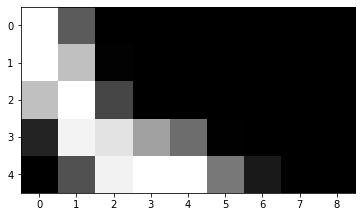

In [14]:
plt.imshow(img_tensor[0,10:15,12:21] , cmap = 'gray')

In [15]:
train_ds , val_ds = random_split(dataset,[50000,10000])

In [16]:
batch_size=128
train_loader = DataLoader(train_ds,batch_size,shuffle = True)
val_loader = DataLoader(val_ds, batch_size)
len(train_loader)

391

In [17]:
input_size = 28*28
num_class = 10

model = nn.Linear(input_size , num_class)

In [60]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size,num_class)
    
    def forward(self,xb):
        xb=xb.reshape(-1,784)
        out=self.linear(xb)
        return out
    
    def training_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss':loss,'val_acc':acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        batch_accs = torch.Tensor(list([x['val_acc'] for x in outputs]))
        epoch_acc = torch.stack(batch_accs).mean()     
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [61]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0082, -0.0221,  0.0284,  ..., -0.0203,  0.0283,  0.0315],
         [ 0.0048, -0.0165,  0.0041,  ..., -0.0318,  0.0232, -0.0076],
         [ 0.0070, -0.0045,  0.0021,  ..., -0.0048, -0.0207,  0.0300],
         ...,
         [ 0.0342, -0.0050, -0.0042,  ..., -0.0061,  0.0176, -0.0097],
         [ 0.0192, -0.0003, -0.0115,  ...,  0.0061,  0.0247,  0.0148],
         [ 0.0155,  0.0048,  0.0172,  ...,  0.0237,  0.0299,  0.0332]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0188,  0.0324, -0.0258, -0.0124, -0.0335,  0.0349,  0.0241, -0.0165,
          0.0012,  0.0308], requires_grad=True)]

In [62]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [63]:
for images , labels in train_loader:
    print(images.shape , labels)
    output = model(images)
    print(output.shape)
    break

torch.Size([128, 1, 28, 28]) tensor([8, 8, 5, 2, 6, 3, 2, 1, 4, 5, 6, 8, 1, 9, 9, 4, 6, 2, 1, 6, 0, 5, 4, 5,
        8, 0, 0, 6, 7, 2, 3, 6, 4, 4, 1, 0, 3, 1, 3, 3, 1, 5, 3, 0, 6, 8, 7, 1,
        5, 6, 5, 5, 6, 7, 0, 2, 5, 5, 3, 5, 8, 2, 0, 7, 6, 1, 9, 2, 2, 0, 9, 3,
        9, 9, 8, 1, 1, 2, 8, 5, 8, 7, 9, 6, 2, 1, 8, 1, 4, 9, 6, 3, 6, 1, 3, 1,
        3, 3, 4, 8, 4, 7, 9, 2, 2, 2, 1, 6, 7, 7, 0, 6, 3, 7, 7, 2, 8, 5, 3, 4,
        2, 2, 5, 3, 2, 9, 5, 3])
torch.Size([128, 10])


In [64]:
prob = F.softmax(output, dim=1)
prob.shape

torch.Size([128, 10])

In [65]:
max_prob,pred = torch.max(prob ,dim=1)

In [66]:
output


tensor([[ 0.2462,  0.0846,  0.0964,  ...,  0.0007, -0.2437, -0.0990],
        [ 0.2176, -0.0733,  0.0545,  ...,  0.1421, -0.0118,  0.2753],
        [ 0.0351, -0.2347, -0.0748,  ...,  0.0340, -0.4901, -0.0184],
        ...,
        [ 0.2461,  0.2414,  0.0226,  ..., -0.0451, -0.0490, -0.0020],
        [ 0.0110,  0.1094, -0.1026,  ...,  0.1137, -0.3813, -0.1205],
        [-0.0636,  0.0985,  0.1031,  ..., -0.0669,  0.0018,  0.1758]],
       grad_fn=<AddmmBackward>)

In [67]:
def accuracy(output , labels):
    _,preds = torch.max(output,dim=1)
    return torch.sum(preds == labels).item()/len(preds)

In [68]:
accuracy(output , labels)

0.09375

In [69]:
loss_function = F.cross_entropy

In [70]:
loss = loss_function(output , labels)
loss

tensor(2.3218, grad_fn=<NllLossBackward>)

In [71]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [72]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [73]:
history0 = fit(1, 0.001, model, train_loader, val_loader)

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [ ]:
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())

In [45]:
def predict_image(img,model):
    xb = img.unsqueeze(0)
    yb =  model(xb)
    _,preds = torch.max(yb, dim=1)
    return preds[0].item()

label: 9  predicted: 1


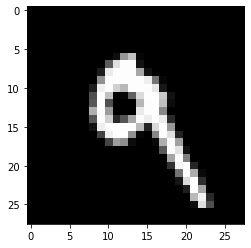

In [47]:
img, label = test_dataset[7]
plt.imshow(img[0],cmap='gray')
print('label:',label,' predicted:', predict_image(img,model))